download historical data

In [5]:
import pandas as pd
import yfinance as yf

# List of top 10 tickers of S&P 500 stocks
tickers = [
    "AAPL",  # Apple Inc.
    "MSFT",  # Microsoft Corporation
    "AMZN",  # Amazon.com Inc.
    "GOOGL",  # Alphabet Inc. (Class A)
    "GOOG",  # Alphabet Inc. (Class C)
    "META",  # Meta Platforms Inc.
    "TSLA",  # Tesla Inc.
    "JPM",  # JPMorgan Chase & Co.
    "NVDA",  # NVIDIA Corporation
    "UNH"   # UnitedHealth Group Incorporated
]

# Download data for the last 1 month to ensure we capture at least 15 market days
data = yf.download(tickers=tickers, period='1mo').stack()
# Clean up the columns and index
data = data.reset_index()  # Reset index to work with columns
data.columns = data.columns.str.replace(' ', '')
data.set_index(['Date', 'Ticker'], inplace=True)  # Set the index back

# Filter to get the last 15 market days
data = data.groupby(level='Ticker').tail(15)
data

[*********************100%***********************]  10 of 10 completed


Price                               AdjClose       Close        High  \
Date                      Ticker                                       
2024-08-20 00:00:00+00:00 AAPL    226.509995  226.509995  227.169998   
                          AMZN    178.880005  178.880005  179.009995   
                          GOOG    168.737885  168.960007  170.410004   
                          GOOGL   166.958450  167.179993  168.639999   
                          JPM     214.520004  214.520004  216.000000   
...                                      ...         ...         ...   
2024-09-10 00:00:00+00:00 META    506.154999  506.154999  514.179993   
                          MSFT    412.399994  412.399994  416.329987   
                          NVDA    107.345001  107.345001  109.400002   
                          TSLA    222.963394  222.963394  226.399994   
                          UNH     600.174988  600.174988  604.630005   

Price                                    Low        Open     Volume  
Date                      Ticker                                     
2024-08-20 00:00:00+00:00 AAPL    225.449997  225.770004   30299000  
                          AMZN    177.429993  177.919998   26255200  
                          GOOG    168.660004  168.740005   12622500  
                          GOOGL   166.820007  166.899994   18341500  
                          JPM     213.679993  215.000000    5640000  
...                                      ...         ...        ...  
2024-09-10 00:00:00+00:00 META    500.027802  507.630005    5734136  
                          MSFT    407.700012  408.179993    9790606  
                          NVDA    104.949997  107.910004  205099842  
                          TSLA    218.637695  220.000000   61574424  
                          UNH     591.150024  595.210022    1439739  

[150 rows x 6 columns]

In [10]:
import numpy as np
from hmmlearn.hmm import GaussianHMM

# Prepare to store the predictions and actual prices for plotting
predicted_close_prices = {}
actual_close_prices = {}

# Loop through each ticker to train HMM and predict prices
for ticker in tickers:
    stock_data = data.xs(ticker, level='Ticker')
    
    # Calculate fractional changes
    stock_data['fracChange'] = (stock_data['Close'] - stock_data['Open']) / stock_data['Open']
    stock_data['fracHigh'] = (stock_data['High'] - stock_data['Open']) / stock_data['Open']
    stock_data['fracLow'] = (stock_data['Open'] - stock_data['Low']) / stock_data['Open']
    
    # Discretize the data
    nfc, nfh, nfl = 50, 10, 10
    fracChange_bins = np.linspace(stock_data['fracChange'].min(), stock_data['fracChange'].max(), nfc)
    fracHigh_bins = np.linspace(stock_data['fracHigh'].min(), stock_data['fracHigh'].max(), nfh)
    fracLow_bins = np.linspace(stock_data['fracLow'].min(), stock_data['fracLow'].max(), nfl)
    
    stock_data['disc_fracChange'] = np.digitize(stock_data['fracChange'], fracChange_bins)
    stock_data['disc_fracHigh'] = np.digitize(stock_data['fracHigh'], fracHigh_bins)
    stock_data['disc_fracLow'] = np.digitize(stock_data['fracLow'], fracLow_bins)
    
    # Combine the discretized features into a single state space
    stock_data['state'] = (stock_data['disc_fracLow'] - 1) * (nfc * nfh) + (stock_data['disc_fracHigh'] - 1) * nfc + stock_data['disc_fracChange']
    
    # Prepare training data
    X = stock_data[['fracChange', 'fracHigh', 'fracLow']].values
    
    # Train the HMM
    model = GaussianHMM(n_components=4, covariance_type="diag", n_iter=1000)
    model.fit(X)
    
    # Predict the stock prices for the last 5 days
    n_days = 5
    bin_size = 10
    predicted_close = []
    
    for i in range(len(stock_data) - n_days, len(stock_data)):
        recent_data = X[i-bin_size:i]
        hidden_states = model.predict(recent_data)
        
        # Predict the next day's state
        next_state = model.transmat_[hidden_states[-1]].argmax()
        mean_fracChange = model.means_[next_state][0]
        
        next_open = stock_data['Open'].iloc[i]
        predicted_close.append(next_open * (1 + mean_fracChange))
    
    # Store the actual and predicted prices
    predicted_close_prices[ticker] = predicted_close
    actual_close_prices[ticker] = stock_data['Close'].iloc[-n_days:].values


Model is not converging.  Current: 92.26459617358813 is not greater than 92.6256166326525. Delta is -0.3610204590643633
Model is not converging.  Current: 91.72986775824376 is not greater than 92.38520097999698. Delta is -0.6553332217532244
Model is not converging.  Current: 87.07317711508355 is not greater than 92.83742611454372. Delta is -5.764248999460165
Model is not converging.  Current: 91.3865789841213 is not greater than 122.74908786323496. Delta is -31.362508879113662
Model is not converging.  Current: 93.60853622076978 is not greater than 93.78603256225047. Delta is -0.1774963414806905
Model is not converging.  Current: 95.86004086469872 is not greater than 95.9063980669205. Delta is -0.04635720222178463
Model is not converging.  Current: 87.71899381311646 is not greater than 91.04937718254159. Delta is -3.3303833694251352
Model is not converging.  Current: 92.00474699355411 is not greater than 92.55818765170572. Delta is -0.5534406581516151
Model is not converging.  Current:

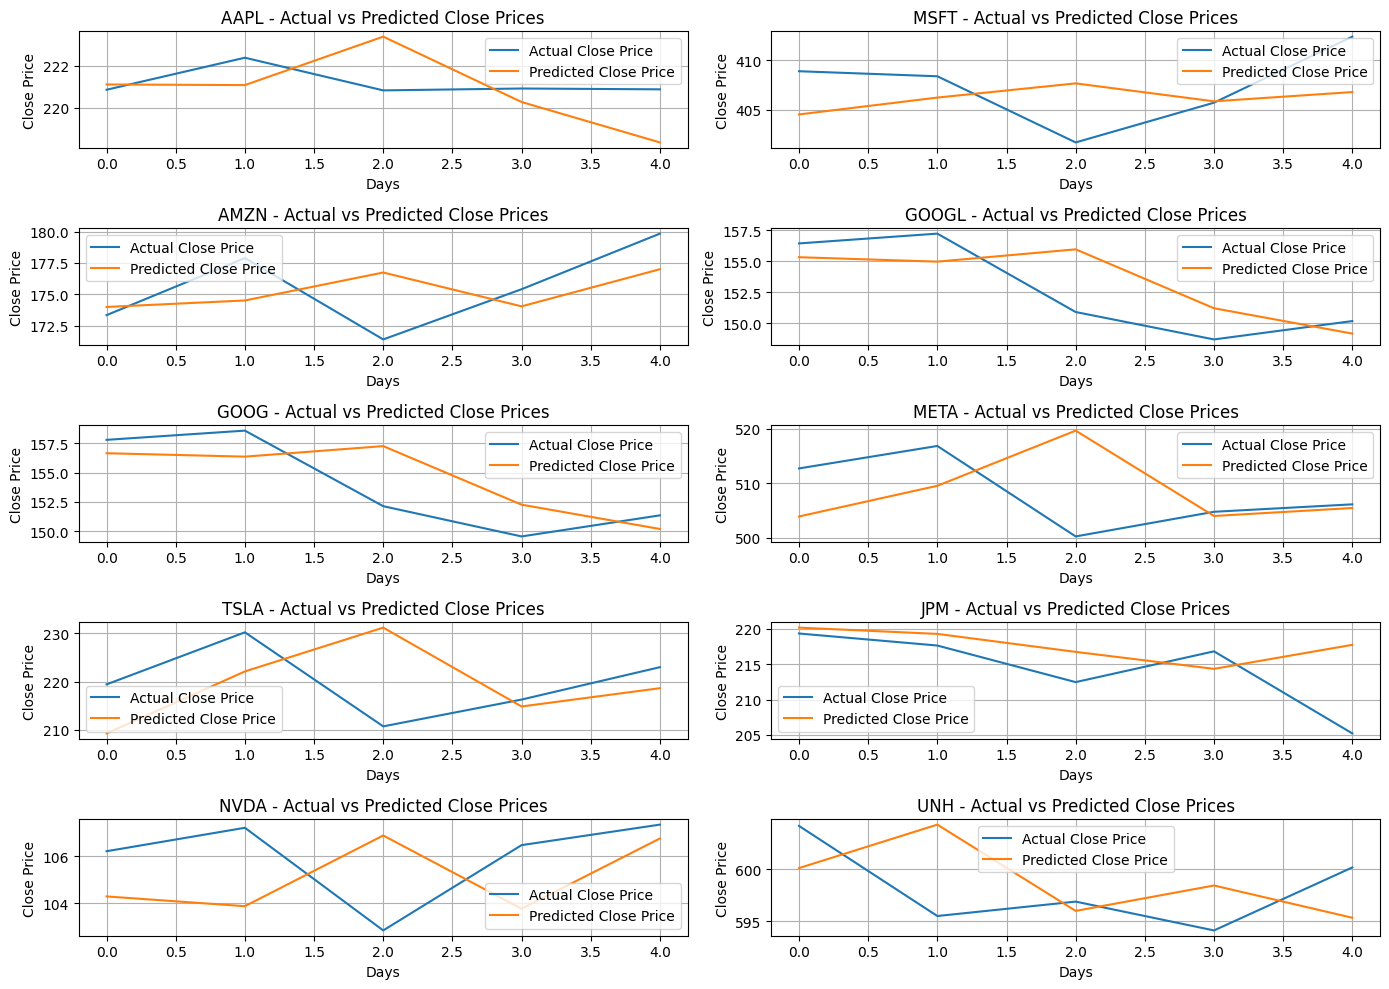

In [11]:
import matplotlib.pyplot as plt

# Plot the actual vs predicted close prices for each stock
plt.figure(figsize=(14, 10))

for i, ticker in enumerate(tickers):
    plt.subplot(5, 2, i+1)
    plt.plot(actual_close_prices[ticker], label='Actual Close Price')
    plt.plot(predicted_close_prices[ticker], label='Predicted Close Price')
    plt.title(f'{ticker} - Actual vs Predicted Close Prices')
    plt.xlabel('Days')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()
